In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.init as init
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset,DataLoader
from copy import deepcopy as dc
import mlflow
import mlflow.pytorch
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.create_experiment("With autologging LSTM_BDL3")
mlflow.set_experiment("With autologging LSTM_BDL3")

<Experiment: artifact_location='mlflow-artifacts:/798755684927768057', creation_time=1716079225132, experiment_id='798755684927768057', last_update_time=1716079225132, lifecycle_stage='active', name='With autologging LSTM_BDL3', tags={}>

In [62]:
mlflow.autolog()

2024/05/19 06:10:25 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/05/19 06:10:25 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2024/05/19 06:10:25 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


In [63]:
def read_data(path):
    data = pd.read_csv(path)
    return data
def extract_T(data):
    data_T = data[['datetime', 'temp']]
    data_T['datetime'] = pd.to_datetime(data_T['datetime'], format='%Y-%m-%d')
    return data_T
#Now to put in format easily readable by pytorch for lstm
def prep_df_lstm(df, n_steps):
    df = dc(df)
    df.set_index('datetime', inplace=True)
    for i in range(1, n_steps + 1):
        df['t-' + str(i)] = df['temp'].shift(i)
    df.dropna(inplace=True)
    return df
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [64]:
def convertscale(data):
    data_np=data.to_numpy()
    scaler=MinMaxScaler()
    data_scaled=scaler.fit_transform(data_np)
    return data_scaled,scaler
def prep_data(data,n_steps):
    #Split into X, y here
    X=data[:,1:]
    y=data[:,0]
    X=dc(np.flip(X,axis=1))
    return X,y
def split_data(X,y,split_index_1,split_index_2):
    X_train=X[:split_index_1]
    y_train=y[:split_index_1]
    X_test=X[split_index_1:split_index_2]
    y_test=y[split_index_1:split_index_2]
    X_val=X[split_index_2:]
    y_val=y[split_index_2:]
    return X_train,y_train,X_test,y_test,X_val,y_val
def reshape_data_tensor(X_train,y_train,X_test,y_test,X_val,y_val,time_period,device): #Here time period is number of days used for predictions in the shifted data
    X_train=X_train.reshape(-1,time_period,1) #Requirement for LSTM in pytorch
    X_test=X_test.reshape(-1,time_period,1)
    y_train=y_train.reshape(-1,1)
    y_test=y_test.reshape(-1,1)
    X_val=X_val.reshape(-1,time_period,1)
    y_val=y_val.reshape(-1,1)
    X_train=torch.tensor(X_train).float().to(device)
    y_train=torch.tensor(y_train).float().to(device)
    X_test=torch.tensor(X_test).float().to(device)
    y_test=torch.tensor(y_test).float().to(device)
    X_val=torch.tensor(X_val).float().to(device)
    y_val=torch.tensor(y_val).float().to(device)
    return X_train,y_train,X_test,y_test,X_val,y_val

In [65]:
class WeatherDataset(Dataset):
    def __init__(self,X,y):
        self.X=X
        self.y=y
    def __len__(self):
        return len(self.X)
    def __getitem__(self,idx):
        return self.X[idx],self.y[idx]
def data_load(X_train,y_train,X_test,y_test,X_val,y_val,batch_size):
    train_dataset=WeatherDataset(X_train,y_train)
    test_dataset=WeatherDataset(X_test,y_test)
    #val_dataset=WeatherDataset(X_val,y_val)
    train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
    test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=True)
    #val_loader=DataLoader(val_dataset,batch_size=batch_size,shuffle=True)
    return train_loader,test_loader
class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers,output_size):
        super(LSTM,self).__init__()
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.lstm=nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)
        self.fc=nn.Linear(hidden_size,output_size)
    def forward(self,x):
        h0=torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)
        c0=torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)
        out,_=self.lstm(x,(h0,c0))
        out=self.fc(out[:,-1,:])
        return out
def train_epoch(epoch):
    model.train(True)
    print(f'Epoch {epoch+1}')
    running_loss=0
    for batch_index,batch in enumerate(train_loader):
        X_batch,y_batch=batch
        output=model(X_batch)
        loss=criterion(output,y_batch)
        running_loss+=loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch_index%100==99:
            avg_loss=running_loss/100
            print(f'Batch : {batch_index+1} Loss : {avg_loss}')
            loss_train.append(avg_loss)
            plt.plot(loss_train)
            plt.show()
            running_loss=0
def validate_epoch():
    model.train(False)
    running_loss=0
    for batch_index,batch in enumerate(test_loader):
        X_batch,y_batch=batch
        with torch.no_grad():
            output=model(X_batch)
            loss=criterion(output,y_batch)
            running_loss+=loss.item()
    avg_loss=running_loss/len(test_loader)
    print(f'Validation Loss : {avg_loss}')
def train_model(lr,num_epochs,criterion,optimizer,scheduler,model,train_loader,test_loader):
    loss_train=[]
    for epoch in range(num_epochs):
        train_epoch(epoch)
        validate_epoch()
        scheduler.step()
def prediction(model,X_input,y_input,time_period,scaler):
    with torch.no_grad():
        predicted=model(X_input).to('cpu').numpy()
    train_predictions=predicted.flatten()
    dummies=np.zeros((X_input.to('cpu').shape[0],time_period+1))
    dummies[:,0]=train_predictions
    dummies=scaler.inverse_transform(dummies)
    train_predictions=dc(dummies[:,0])
    dummies=np.zeros((X_input.to('cpu').shape[0],time_period+1))
    dummies[:,0]=y_input.to('cpu').numpy().flatten()
    dummies=scaler.inverse_transform(dummies)
    new_y_train=dc(dummies[:,0]) 
    return train_predictions,new_y_train
def plot_predictions(train_predictions,new_y_train):
    plt.plot(new_y_train,label='Actual')
    plt.plot(train_predictions,label='Predicted')
    plt.legend()
    plt.show()
def mean_error(train_predictions,new_y_train):
    error=np.mean(np.abs(train_predictions-new_y_train))
    print(f'Mean Error : {error}')
    return error

Experiment 1:

C:\Users\sriva\AppData\Local\Temp\ipykernel_4408\1020498080.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_T['datetime'] = pd.to_datetime(data_T['datetime'], format='%Y-%m-%d')


Epoch 1
Validation Loss : 0.020897030209501583
Epoch 2
Validation Loss : 0.00652453675866127
Epoch 3
Validation Loss : 0.01823854601631562
Epoch 4
Validation Loss : 0.00874704448506236
Epoch 5
Validation Loss : 0.010680977565546831
Epoch 6
Validation Loss : 0.007375820229450862
Epoch 7
Validation Loss : 0.005632393682996432
Epoch 8
Validation Loss : 0.006955710705369711
Epoch 9
Validation Loss : 0.0054848166182637215
Epoch 10
Validation Loss : 0.005353229586035013


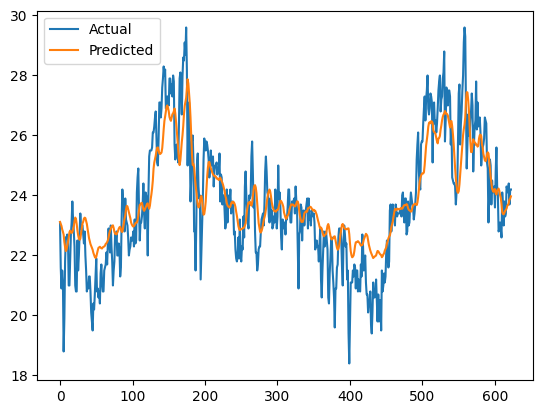

Mean Error : 0.9246484870153869


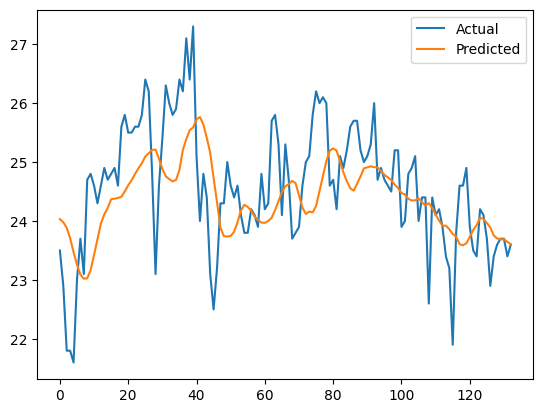

Mean Error : 0.7521461032387008


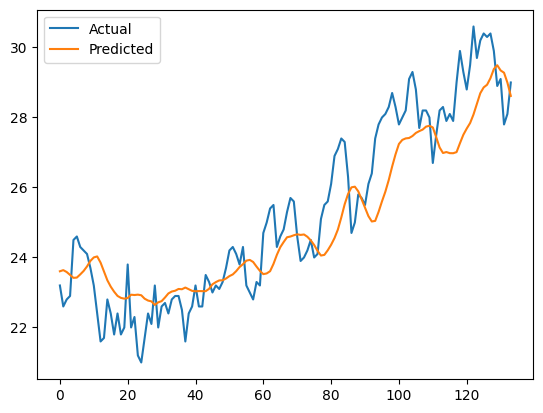

2024/05/19 06:10:27 WARNING mlflow.utils.requirements_utils: Found torch version (2.2.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.2.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Mean Error : 0.937167703638326
0.937167703638326


2024/05/19 06:10:33 WARNING mlflow.utils.requirements_utils: Found torch version (2.2.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.2.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
c:\Users\sriva\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [66]:
with mlflow.start_run(run_name="Model 1"):   
    data=read_data(r"C:\Users\sriva\OneDrive\Documents\GitHub\FinalProject_BDL\Bangalore,India 2021-10-30 to 2024-04-13.csv")
    learning_rate=0.001
    epochs=10
    data_T=extract_T(data)
    data_T=prep_df_lstm(data_T,7)
    data_scaled,scaler=convertscale(data_T)
    X,y=prep_data(data_scaled,7)
    split_index_1=int(0.7*len(X))
    split_index_2=int(0.85*len(X))
    X_train,y_train,X_test,y_test,X_val,y_val=split_data(X,y,split_index_1,split_index_2)
    X_train,y_train,X_test,y_test,X_val,y_val=reshape_data_tensor(X_train,y_train,X_test,y_test,X_val,y_val,7,device)
    train_loader,test_loader=data_load(X_train,y_train,X_test,y_test,X_val,y_val,64)
    model=LSTM(1,64,2,1).to(device)
    criterion=nn.MSELoss()
    optimizer=optim.Adam(model.parameters(),lr=learning_rate)
    scheduler=lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)
    train_model(learning_rate,epochs,criterion,optimizer,scheduler,model,train_loader,test_loader)
    train_predictions,new_y_train=prediction(model,X_train,y_train,7,scaler)
    plot_predictions(train_predictions,new_y_train)
    mean_error(train_predictions,new_y_train)
    test_predictions,new_y_test=prediction(model,X_test,y_test,7,scaler)
    plot_predictions(test_predictions,new_y_test)
    mean_error(test_predictions,new_y_test)
    val_predictions,new_y_val=prediction(model,X_val,y_val,7,scaler)
    plot_predictions(val_predictions,new_y_val)
    error=mean_error(val_predictions,new_y_val)
    mlflow.log_metric("Error",error)
    mlflow.log_param("Learning rate",learning_rate)
    mlflow.log_param("Epoch count",epochs)
#Save model
    print(error)
    torch.save(model.state_dict(), "C:\\Users\\sriva\\OneDrive\\Documents\\GitHub\\FinalProject_BDL\model2.pth")
    mlflow.pytorch.log_model(model, "model")

Experiment 2


C:\Users\sriva\AppData\Local\Temp\ipykernel_4408\1020498080.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_T['datetime'] = pd.to_datetime(data_T['datetime'], format='%Y-%m-%d')


Epoch 1
Validation Loss : 0.06864028299848239
Epoch 2
Validation Loss : 0.00836489861831069
Epoch 3
Validation Loss : 0.03401795526345571
Epoch 4
Validation Loss : 0.006298204263051351
Epoch 5
Validation Loss : 0.00906378279129664
Epoch 6
Validation Loss : 0.007545682446410258
Epoch 7
Validation Loss : 0.007145369735856851
Epoch 8
Validation Loss : 0.006560973823070526
Epoch 9
Validation Loss : 0.00521336627813677
Epoch 10
Validation Loss : 0.0067134538354973


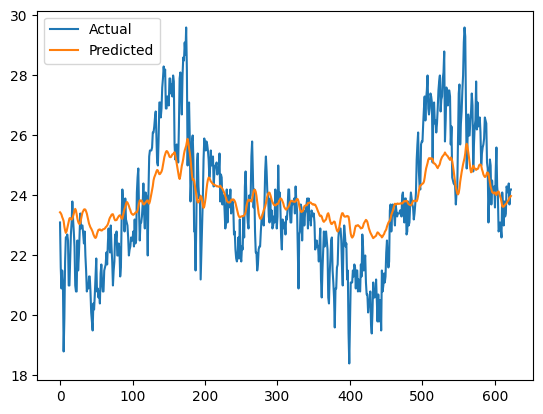

Mean Error : 1.2000398798054908


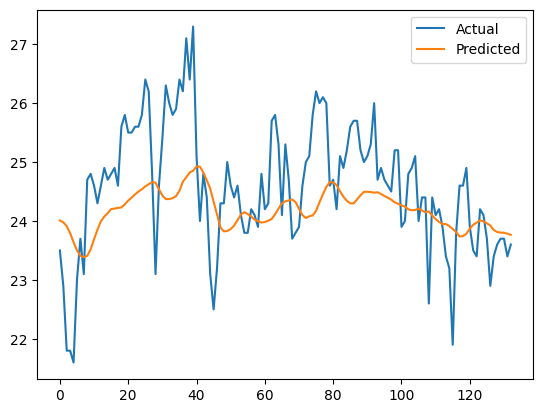

Mean Error : 0.8058285810893638


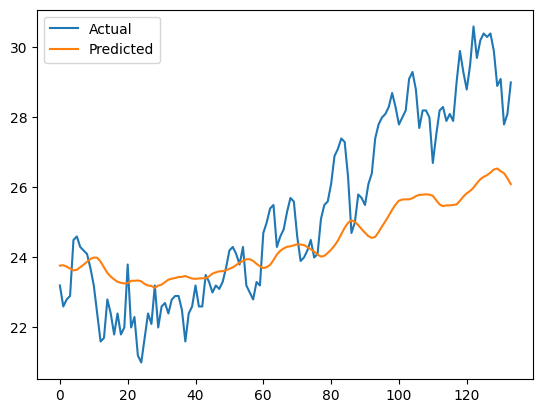

2024/05/19 06:10:34 WARNING mlflow.utils.requirements_utils: Found torch version (2.2.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.2.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Mean Error : 1.5369806439351685
1.5369806439351685


2024/05/19 06:10:38 WARNING mlflow.utils.requirements_utils: Found torch version (2.2.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.2.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


In [67]:
with mlflow.start_run(run_name="Model 2"):
    data=read_data(r"C:\Users\sriva\OneDrive\Documents\GitHub\FinalProject_BDL\Bangalore,India 2021-10-30 to 2024-04-13.csv")
    learning_rate=0.001
    epochs=10
    data_T=extract_T(data)
    data_T=prep_df_lstm(data_T,7)
    data_scaled,scaler=convertscale(data_T)
    X,y=prep_data(data_scaled,7)
    split_index_1=int(0.7*len(X))
    split_index_2=int(0.85*len(X))
    X_train,y_train,X_test,y_test,X_val,y_val=split_data(X,y,split_index_1,split_index_2)
    X_train,y_train,X_test,y_test,X_val,y_val=reshape_data_tensor(X_train,y_train,X_test,y_test,X_val,y_val,7,device)
    train_loader,test_loader=data_load(X_train,y_train,X_test,y_test,X_val,y_val,64)
    model=LSTM(1,64,2,1).to(device)
    criterion=nn.MSELoss()
    optimizer=optim.Adam(model.parameters(),lr=learning_rate)
    scheduler=lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)
    train_model(learning_rate,epochs,criterion,optimizer,scheduler,model,train_loader,test_loader)
    train_predictions,new_y_train=prediction(model,X_train,y_train,7,scaler)
    plot_predictions(train_predictions,new_y_train)
    mean_error(train_predictions,new_y_train)
    test_predictions,new_y_test=prediction(model,X_test,y_test,7,scaler)
    plot_predictions(test_predictions,new_y_test)
    mean_error(test_predictions,new_y_test)
    val_predictions,new_y_val=prediction(model,X_val,y_val,7,scaler)
    plot_predictions(val_predictions,new_y_val)
    error=mean_error(val_predictions,new_y_val)
    print(error)
    mlflow.log_metric("Error",error)
    mlflow.log_param("Learning rate",learning_rate)
    mlflow.log_param("Epoch count",epochs)
#Save model
    torch.save(model.state_dict(), "C:\\Users\\sriva\\OneDrive\\Documents\\GitHub\\FinalProject_BDL\model3ml.pth")
    mlflow.pytorch.log_model(model, "model")

Experiment 3

C:\Users\sriva\AppData\Local\Temp\ipykernel_4408\1020498080.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_T['datetime'] = pd.to_datetime(data_T['datetime'], format='%Y-%m-%d')


Epoch 1
Validation Loss : 0.012763360825677713
Epoch 2
Validation Loss : 0.02939244732260704
Epoch 3
Validation Loss : 0.00755837590744098
Epoch 4
Validation Loss : 0.008051873107130328
Epoch 5
Validation Loss : 0.005569519009441137
Epoch 6
Validation Loss : 0.005328300564239423
Epoch 7
Validation Loss : 0.007008359457055728
Epoch 8
Validation Loss : 0.009551582237084707
Epoch 9
Validation Loss : 0.005727540934458375
Epoch 10
Validation Loss : 0.005769899891068538
Epoch 11
Validation Loss : 0.005340317535835008
Epoch 12
Validation Loss : 0.0068322885781526566
Epoch 13
Validation Loss : 0.009380242476860682
Epoch 14
Validation Loss : 0.007286534955104192
Epoch 15
Validation Loss : 0.005502850127716859
Epoch 16
Validation Loss : 0.005958269505451123
Epoch 17
Validation Loss : 0.006730410580833753
Epoch 18
Validation Loss : 0.0071240571948389215
Epoch 19
Validation Loss : 0.006971740784744422
Epoch 20
Validation Loss : 0.006432108270625274
Epoch 21
Validation Loss : 0.008783552174766859
E

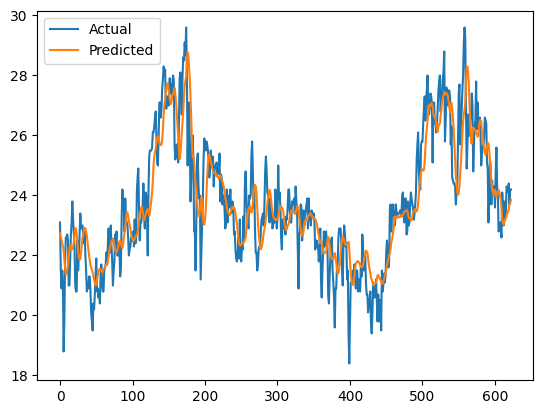

Mean Error : 0.8178396691264733


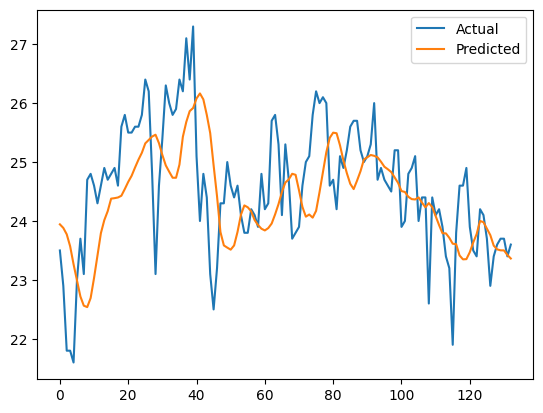

Mean Error : 0.7866511499971375


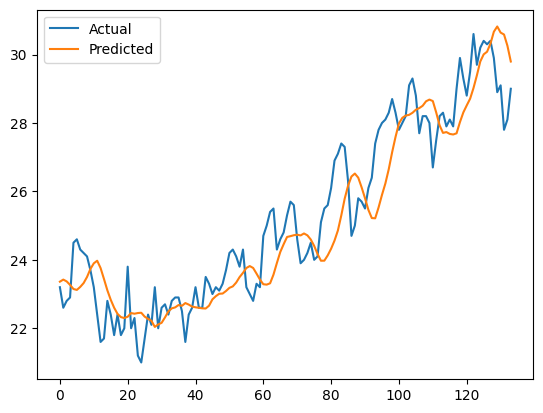

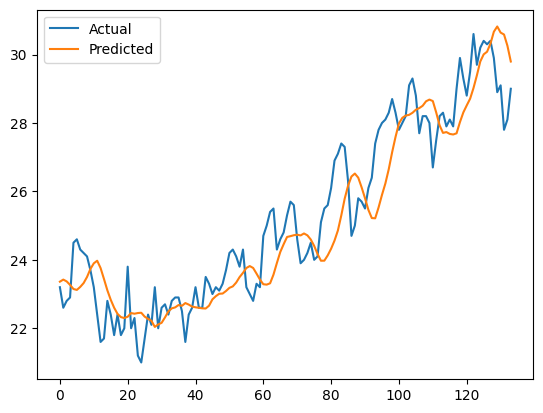

Mean Error : 0.8232598907689551
0.8232598907689551


2024/05/19 06:10:41 WARNING mlflow.utils.requirements_utils: Found torch version (2.2.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.2.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/05/19 06:10:45 WARNING mlflow.utils.requirements_utils: Found torch version (2.2.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.2.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


In [68]:
with mlflow.start_run(run_name="Model 3"):
    data=read_data(r"C:\Users\sriva\OneDrive\Documents\GitHub\FinalProject_BDL\Bangalore,India 2021-10-30 to 2024-04-13.csv")
    learning_rate=0.001
    epochs=50
    data_T=extract_T(data)
    data_T=prep_df_lstm(data_T,7)
    data_scaled,scaler=convertscale(data_T)
    X,y=prep_data(data_scaled,7)
    split_index_1=int(0.7*len(X))
    split_index_2=int(0.85*len(X))
    X_train,y_train,X_test,y_test,X_val,y_val=split_data(X,y,split_index_1,split_index_2)
    X_train,y_train,X_test,y_test,X_val,y_val=reshape_data_tensor(X_train,y_train,X_test,y_test,X_val,y_val,7,device)
    train_loader,test_loader=data_load(X_train,y_train,X_test,y_test,X_val,y_val,64)
    model=LSTM(1,128,2,1).to(device)
    criterion=nn.MSELoss()
    optimizer=optim.Adam(model.parameters(),lr=learning_rate)
    scheduler=lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)
    train_model(learning_rate,epochs,criterion,optimizer,scheduler,model,train_loader,test_loader)
    train_predictions,new_y_train=prediction(model,X_train,y_train,7,scaler)
    plot_predictions(train_predictions,new_y_train)
    mean_error(train_predictions,new_y_train)
    test_predictions,new_y_test=prediction(model,X_test,y_test,7,scaler)
    plot_predictions(test_predictions,new_y_test)
    mean_error(test_predictions,new_y_test)
    val_predictions,new_y_val=prediction(model,X_val,y_val,7,scaler)
    plot_predictions(val_predictions,new_y_val)
    plot_predictions(val_predictions,new_y_val)
    error=mean_error(val_predictions,new_y_val)
#Save model
    print(error)
    mlflow.log_metric("Error",error)
    mlflow.log_param("Learning rate",learning_rate)
    mlflow.log_param("Epoch count",epochs)
#Save model
    torch.save(model.state_dict(), "C:\\Users\\sriva\\OneDrive\\Documents\\GitHub\\FinalProject_BDL\model4ml.pth")
    mlflow.pytorch.log_model(model, "model")

Experiment 4

C:\Users\sriva\AppData\Local\Temp\ipykernel_4408\1020498080.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_T['datetime'] = pd.to_datetime(data_T['datetime'], format='%Y-%m-%d')


Epoch 1
Validation Loss : 0.005319454940035939
Epoch 2
Validation Loss : 0.016704019779960316
Epoch 3
Validation Loss : 0.007170948510368665
Epoch 4
Validation Loss : 0.0050313209649175406
Epoch 5
Validation Loss : 0.00771750183776021
Epoch 6
Validation Loss : 0.005407814945404728
Epoch 7
Validation Loss : 0.005796490547557672
Epoch 8
Validation Loss : 0.005893629044294357
Epoch 9
Validation Loss : 0.003760389886641254
Epoch 10
Validation Loss : 0.0053131962195038795
Epoch 11
Validation Loss : 0.004686707087482016
Epoch 12
Validation Loss : 0.0037073231069371104
Epoch 13
Validation Loss : 0.006081621007372935
Epoch 14
Validation Loss : 0.006102952019621928
Epoch 15
Validation Loss : 0.0048389316846927
Epoch 16
Validation Loss : 0.005405870887140433
Epoch 17
Validation Loss : 0.004433876213928063
Epoch 18
Validation Loss : 0.0040875635265062256
Epoch 19
Validation Loss : 0.004763778454313676
Epoch 20
Validation Loss : 0.004583008664970596
Epoch 21
Validation Loss : 0.004404679328824083


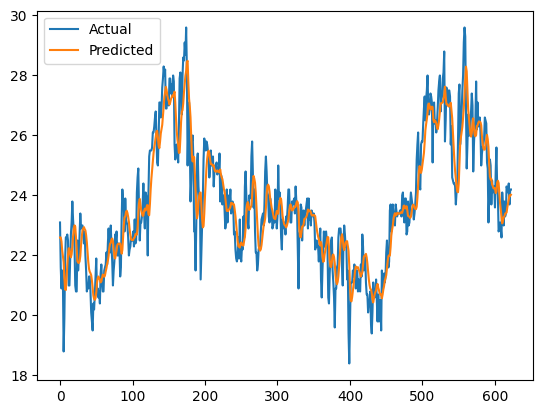

Mean Error : 0.7123687638014701


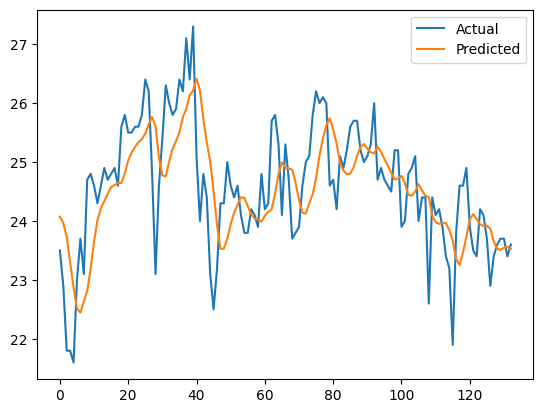

Mean Error : 0.6827179350799187


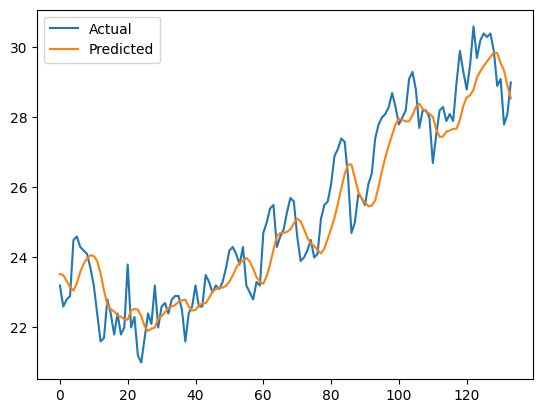

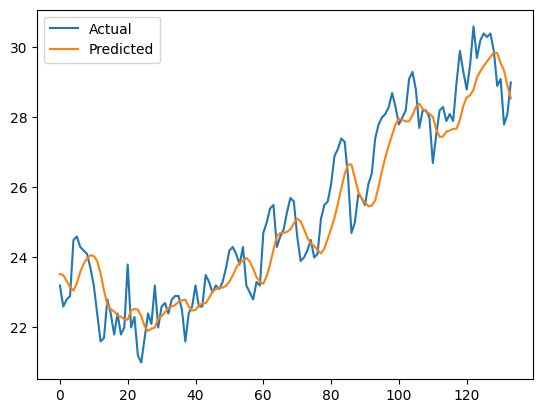

2024/05/19 06:10:54 WARNING mlflow.utils.requirements_utils: Found torch version (2.2.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.2.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Mean Error : 0.6907629351784935
0.6907629351784935


2024/05/19 06:10:58 WARNING mlflow.utils.requirements_utils: Found torch version (2.2.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.2.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


In [69]:
with mlflow.start_run(run_name="Model 4"):
    data=read_data(r"C:\Users\sriva\OneDrive\Documents\GitHub\FinalProject_BDL\Bangalore,India 2021-10-30 to 2024-04-13.csv")
    learning_rate=0.005
    epochs=100
    data_T=extract_T(data)
    data_T=prep_df_lstm(data_T,7)
    data_scaled,scaler=convertscale(data_T)
    X,y=prep_data(data_scaled,7)
    split_index_1=int(0.7*len(X))
    split_index_2=int(0.85*len(X))
    X_train,y_train,X_test,y_test,X_val,y_val=split_data(X,y,split_index_1,split_index_2)
    X_train,y_train,X_test,y_test,X_val,y_val=reshape_data_tensor(X_train,y_train,X_test,y_test,X_val,y_val,7,device)
    train_loader,test_loader=data_load(X_train,y_train,X_test,y_test,X_val,y_val,64)
    model=LSTM(1,128,2,1).to(device)
    criterion=nn.MSELoss()
    optimizer=optim.Adam(model.parameters(),lr=learning_rate)
    scheduler=lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)
    train_model(learning_rate,epochs,criterion,optimizer,scheduler,model,train_loader,test_loader)
    train_predictions,new_y_train=prediction(model,X_train,y_train,7,scaler)
    plot_predictions(train_predictions,new_y_train)
    mean_error(train_predictions,new_y_train)
    test_predictions,new_y_test=prediction(model,X_test,y_test,7,scaler)
    plot_predictions(test_predictions,new_y_test)
    mean_error(test_predictions,new_y_test)
    val_predictions,new_y_val=prediction(model,X_val,y_val,7,scaler)
    plot_predictions(val_predictions,new_y_val)
    plot_predictions(val_predictions,new_y_val)
    error=mean_error(val_predictions,new_y_val)
#Save model
    print(error)
    mlflow.log_metric("Error",error)
    mlflow.log_param("Learning rate",learning_rate)
    mlflow.log_param("Epoch count",epochs)
#Save model
    torch.save(model.state_dict(), "C:\\Users\\sriva\\OneDrive\\Documents\\GitHub\\FinalProject_BDL\model5ml.pth")
    mlflow.pytorch.log_model(model, "model")

Experiment 5

C:\Users\sriva\AppData\Local\Temp\ipykernel_4408\1020498080.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_T['datetime'] = pd.to_datetime(data_T['datetime'], format='%Y-%m-%d')


Epoch 1
Validation Loss : 0.009187902323901653
Epoch 2
Validation Loss : 0.0111466059461236
Epoch 3
Validation Loss : 0.005844255909323692
Epoch 4
Validation Loss : 0.00596220139414072
Epoch 5
Validation Loss : 0.009659401141107082
Epoch 6
Validation Loss : 0.0056801228784024715
Epoch 7
Validation Loss : 0.004877832252532244
Epoch 8
Validation Loss : 0.00523380097001791
Epoch 9
Validation Loss : 0.00499822199344635
Epoch 10
Validation Loss : 0.00501401349902153
Epoch 11
Validation Loss : 0.004942568019032478
Epoch 12
Validation Loss : 0.005233458708971739
Epoch 13
Validation Loss : 0.004935430828481913
Epoch 14
Validation Loss : 0.0046852570958435535
Epoch 15
Validation Loss : 0.0047396644949913025
Epoch 16
Validation Loss : 0.004837897140532732
Epoch 17
Validation Loss : 0.00485253194347024
Epoch 18
Validation Loss : 0.004812721163034439
Epoch 19
Validation Loss : 0.00481007806956768
Epoch 20
Validation Loss : 0.004892128054052591
Epoch 21
Validation Loss : 0.004816815257072449
Epoch 

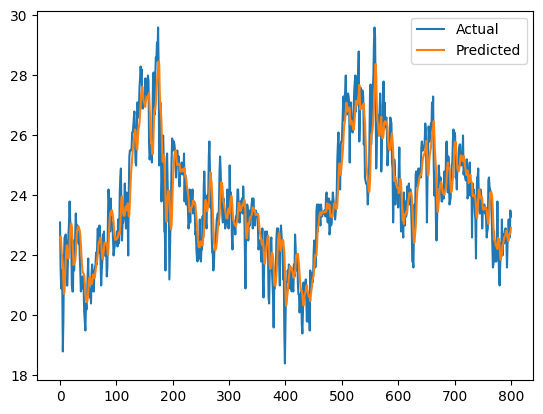

Mean Error : 0.6756058920616663


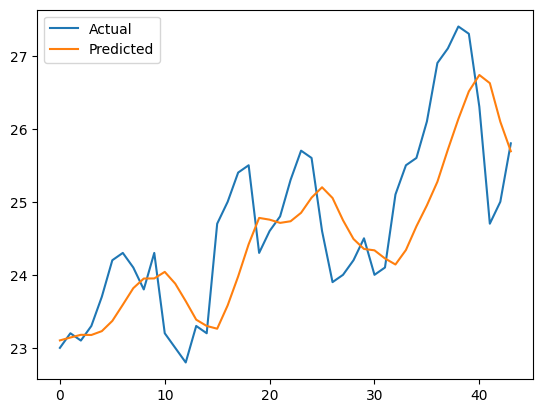

Mean Error : 0.6857135485519062


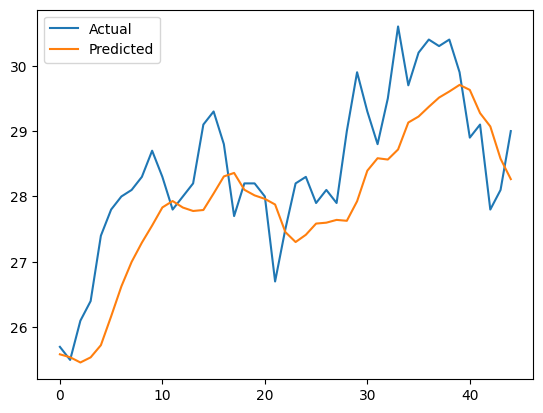

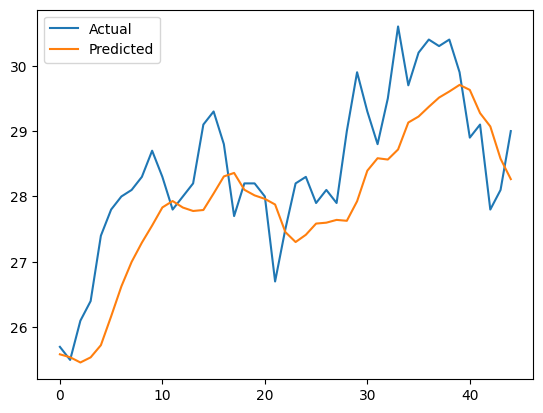

2024/05/19 06:11:11 WARNING mlflow.utils.requirements_utils: Found torch version (2.2.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.2.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Mean Error : 0.7535366426573862
0.7535366426573862


2024/05/19 06:11:15 WARNING mlflow.utils.requirements_utils: Found torch version (2.2.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.2.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


In [70]:
with mlflow.start_run(run_name="Model 5"):
    data=read_data(r"C:\Users\sriva\OneDrive\Documents\GitHub\FinalProject_BDL\Bangalore,India 2021-10-30 to 2024-04-13.csv")
    learning_rate=0.005
    epochs=100
    data_T=extract_T(data)
    data_T=prep_df_lstm(data_T,7)
    data_scaled,scaler=convertscale(data_T)
    X,y=prep_data(data_scaled,7)
    split_index_1=int(0.9*len(X))
    split_index_2=int(0.95*len(X))
    X_train,y_train,X_test,y_test,X_val,y_val=split_data(X,y,split_index_1,split_index_2)
    X_train,y_train,X_test,y_test,X_val,y_val=reshape_data_tensor(X_train,y_train,X_test,y_test,X_val,y_val,7,device)
    train_loader,test_loader=data_load(X_train,y_train,X_test,y_test,X_val,y_val,64)
    model=LSTM(1,128,2,1).to(device)
    criterion=nn.MSELoss()
    optimizer=optim.Adam(model.parameters(),lr=learning_rate)
    scheduler=lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)
    train_model(learning_rate,epochs,criterion,optimizer,scheduler,model,train_loader,test_loader)
    train_predictions,new_y_train=prediction(model,X_train,y_train,7,scaler)
    plot_predictions(train_predictions,new_y_train)
    mean_error(train_predictions,new_y_train)
    test_predictions,new_y_test=prediction(model,X_test,y_test,7,scaler)
    plot_predictions(test_predictions,new_y_test)
    mean_error(test_predictions,new_y_test)
    val_predictions,new_y_val=prediction(model,X_val,y_val,7,scaler)
    plot_predictions(val_predictions,new_y_val)
    plot_predictions(val_predictions,new_y_val)
    error=mean_error(val_predictions,new_y_val)
#Save model
    print(error)
    mlflow.log_metric("Error",error)
    mlflow.log_param("Learning rate",learning_rate)
    mlflow.log_param("Epoch count",epochs)
#Save model
    torch.save(model.state_dict(), "C:\\Users\\sriva\\OneDrive\\Documents\\GitHub\\FinalProject_BDL\model6ml.pth")
    mlflow.pytorch.log_model(model, "model")

Experiment 6


C:\Users\sriva\AppData\Local\Temp\ipykernel_4408\1020498080.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_T['datetime'] = pd.to_datetime(data_T['datetime'], format='%Y-%m-%d')


Epoch 1
Validation Loss : 0.08722913265228271
Epoch 2
Validation Loss : 0.03442538529634476
Epoch 3
Validation Loss : 0.020633595064282417
Epoch 4
Validation Loss : 0.01157919317483902
Epoch 5
Validation Loss : 0.007153504993766546
Epoch 6
Validation Loss : 0.009118844754993916
Epoch 7
Validation Loss : 0.006422565784305334
Epoch 8
Validation Loss : 0.007396304048597813
Epoch 9
Validation Loss : 0.006856222171336412
Epoch 10
Validation Loss : 0.007556521333754063
Epoch 11
Validation Loss : 0.006960807368159294
Epoch 12
Validation Loss : 0.007399318739771843
Epoch 13
Validation Loss : 0.006987869739532471
Epoch 14
Validation Loss : 0.006809247191995382
Epoch 15
Validation Loss : 0.006867723073810339
Epoch 16
Validation Loss : 0.006964416708797216
Epoch 17
Validation Loss : 0.007059996947646141
Epoch 18
Validation Loss : 0.007046926766633987
Epoch 19
Validation Loss : 0.0070191496051847935
Epoch 20
Validation Loss : 0.007026980631053448
Epoch 21
Validation Loss : 0.007044137455523014
Epo

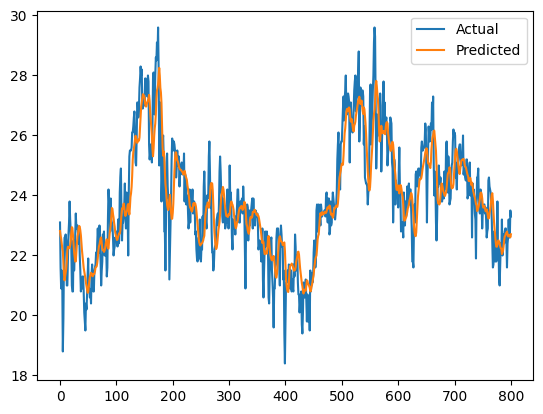

Mean Error : 0.7690207687191453


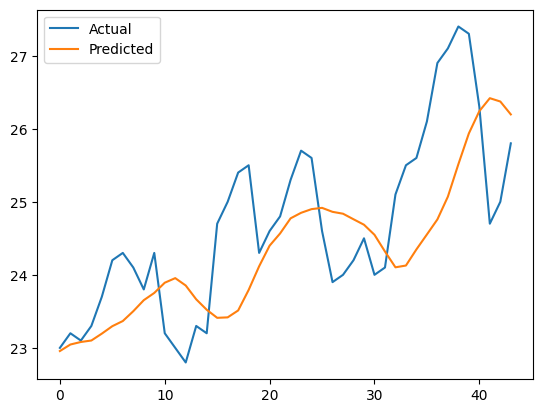

Mean Error : 0.8264667152003805


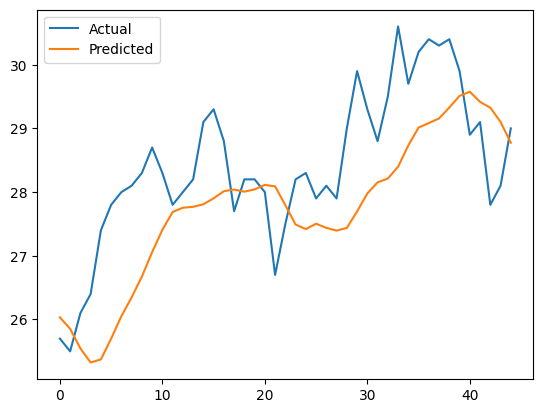

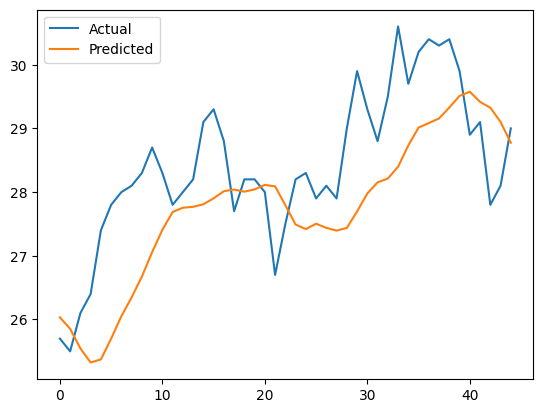

2024/05/19 06:11:22 WARNING mlflow.utils.requirements_utils: Found torch version (2.2.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.2.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Mean Error : 0.9612400492032372
0.9612400492032372


2024/05/19 06:11:26 WARNING mlflow.utils.requirements_utils: Found torch version (2.2.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.2.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


In [71]:
with mlflow.start_run(run_name="Model 6"):
    data=read_data(r"C:\Users\sriva\OneDrive\Documents\GitHub\FinalProject_BDL\Bangalore,India 2021-10-30 to 2024-04-13.csv")
    learning_rate=0.005
    epochs=100
    data_T=extract_T(data)
    data_T=prep_df_lstm(data_T,7)
    data_scaled,scaler=convertscale(data_T)
    X,y=prep_data(data_scaled,7)
    split_index_1=int(0.9*len(X))
    split_index_2=int(0.95*len(X))
    X_train,y_train,X_test,y_test,X_val,y_val=split_data(X,y,split_index_1,split_index_2)
    X_train,y_train,X_test,y_test,X_val,y_val=reshape_data_tensor(X_train,y_train,X_test,y_test,X_val,y_val,7,device)
    train_loader,test_loader=data_load(X_train,y_train,X_test,y_test,X_val,y_val,64)
    model=LSTM(1,256,2,1).to(device)
    criterion=nn.MSELoss()
    optimizer=optim.Adam(model.parameters(),lr=learning_rate)
    scheduler=lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)
    train_model(learning_rate,epochs,criterion,optimizer,scheduler,model,train_loader,test_loader)
    train_predictions,new_y_train=prediction(model,X_train,y_train,7,scaler)
    plot_predictions(train_predictions,new_y_train)
    mean_error(train_predictions,new_y_train)
    test_predictions,new_y_test=prediction(model,X_test,y_test,7,scaler)
    plot_predictions(test_predictions,new_y_test)
    mean_error(test_predictions,new_y_test)
    val_predictions,new_y_val=prediction(model,X_val,y_val,7,scaler)
    plot_predictions(val_predictions,new_y_val)
    plot_predictions(val_predictions,new_y_val)
    error=mean_error(val_predictions,new_y_val)
#Save model
    print(error)
    mlflow.log_metric("Error",error)
    mlflow.log_param("Learning rate",learning_rate)
    mlflow.log_param("Epoch count",epochs)
#Save model
    torch.save(model.state_dict(), "C:\\Users\\sriva\\OneDrive\\Documents\\GitHub\\FinalProject_BDL\model7ml.pth")
    mlflow.pytorch.log_model(model, "model")